### General Report

Determine the actual cargo capacity from history data defined from 2 sources:  
The number of flights that have traveled between different airports   
The total amount of volume and/or weight that can be shipped if an aircraft would
be fully packed  

Tech used: 
- Pandas
- Seaborn
- Scikit-learn

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set_theme(style="white")

#### Question 1
Access the available datasets and EDA

The datasets are CSV and JSON type, easy to read with pandas library and then analyse and process it

In [4]:
# repo was previously in a zipped folder, and was manually extracted
dir = './data/flight_events/' 
filename = '2022-10-03.csv'
flight_events = pd.read_csv(dir+filename, delimiter=';') # Load the CSV
sampled_flight_events = flight_events.sample(n=1000)  # Sample 1000 rows for analysis
sampled_flight_events.head()

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time
15060,A7946A,32000,JBU1328,2022-10-03,GUA,MGGT,A320,cruising,B61328,766610276,39.85440,-76.10535,JBU,JFK,KJFK,N588JB,00:35:22
1786,06A0EA,39900,QTR945,2022-10-03,DOH,OTHH,A359,descent,QR945,766571550,24.51911,53.93411,QTR,SIN,WSSS,A7-AMK,01:32:28
63231,A1ADAB,0,SKW5306,2022-10-03,ACV,KACV,E75L,landed,UA5306,766627600,40.98088,-124.11015,SKW,SFO,KSFO,N207SY,02:22:49
87263,C81D86,1800,ZKHIW,2022-10-03,TUO,NZAP,R44,takeoff,NaN,766634690,-38.64287,176.09192,NaN,NaN,NaN,ZK-HIW,02:40:13
33198,AC0B50,35000,SWA1089,2022-10-03,SJC,KSJC,B38M,cruising,WN1089,766618800,22.44502,-155.53340,SWA,HNL,PHNL,N8750Q,01:08:42


In [169]:
filtered_df = flight_events[flight_events['address'] == 'A97626']
filtered_df.head()

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time
33145,A97626,0,SKW5949,2022-10-03,SBP,KSBP,CRJ2,gate_departure,UA5949,766618783,37.62079,-122.38635,SKW,SFO,KSFO,N709BR,00:09:05
33146,A97626,75,SKW5949,2022-10-03,SBP,KSBP,CRJ2,takeoff,UA5949,766618783,37.62357,-122.37259,SKW,SFO,KSFO,N709BR,00:18:21
33147,A97626,27025,SKW5949,2022-10-03,SBP,KSBP,CRJ2,cruising,UA5949,766618783,36.43681,-121.89635,SKW,SFO,KSFO,N709BR,00:37:59
33148,A97626,26825,SKW5949,2022-10-03,SBP,KSBP,CRJ2,descent,UA5949,766618783,36.24385,-121.71233,SKW,SFO,KSFO,N709BR,00:38:27
33149,A97626,0,SKW5949,2022-10-03,SBP,KSBP,CRJ2,landed,UA5949,766618783,35.24131,-120.64609,SKW,SFO,KSFO,N709BR,01:00:19


Each address represents a single airplane, so we could expect rows with the same address to have events like 'Gate_departure', 'Takeoff', 'Cruising', 'Landed', 'Gate_arrival', etc.   
For this task the relevant fields are **flight_id, date, destination, equipment, origin**, as flight id is the unique identifier for each flight an aircraft does.  
Destination and origin give us the airports this flight traveled, equipment gives the type of aircraft, that can be matched with *airplane_details.json* to get the cargo capacity of that flight.

In [13]:
def summarize(df, filename, n_rows_to_show=5):
    """Simply summarize the given DataFrame.
    
    Parameters:
        df: pd.DataFrame, raw DataFrame
        n_rows_to_show: int, number of rows to show 
    """
    print(f"=====Summary of {filename}=====")
    print(f"Shape: {df.shape}")
    
    nan_ratio = pd.isna(df).sum() / len(df) * 100
    nan_ratio.sort_values(ascending=False, inplace=True)
    nan_ratio = nan_ratio.to_frame(name='NaN Ratio').T
    print("NaN ratio:")
    display(nan_ratio)   

In [20]:
summarize(sampled_flight_events, filename)

=====Summary of 2022-10-03.csv=====
Shape: (1000, 17)
NaN ratio:


,flight,operator,origin_iata,origin_icao,destination_iata,destination_icao,callsign,registration,equipment,address,event,altitude,date,longitude,latitude,flight_id,time
NaN Ratio,17.6,16.4,4.8,4.6,4.5,4.3,1.5,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As expected from the data documentation, there are some missing values in some of the fields. The percentage is low for the relevant fields and the quantity of data is high, 100k rows per CSV.

In [6]:
airplane_df = pd.read_json('./data/airplane_details.json', lines=True)
airplane_df.head()

,code_iata,code_icao,full_name,category,average_speed_mph,volume,payload
0,388,A388,Airbus A380-800,A380,550,86.74944,83417.6077
1,351,A35K,Airbus A350-1000,A350,558,120.12864,66242.9000
2,788,B788,Boeing B787-8,B787,570,74.78400,40610.8525
3,M82,MD82,Boeing MD80-82,MD80,461,9.85872,17989.3965
4,AR8,RJ85,Avro RJ85,RJ,368,3.92160,12136.2925


In [28]:
summarize(airplane_df, filename2)

=====Summary of airplane_details.json=====
Shape: (100, 7)
NaN ratio:


,volume,category,code_iata,full_name,code_icao,average_speed_mph,payload
NaN Ratio,43.0,1.0,0.0,0.0,0.0,0.0,0.0


Volume data[m3] is missing in half the airplanes but payload[kg] is 100% present, the matching column is code_icao, the ICAO Aircraft Type designator

When it comes to calculating the actual cargo capacity of a flight, its extremely important both the volume capacity and the payload capacity. Missing half the data on volume capacity means the analysis will be significantly impacted as, even if we have perfect cargo capacity assessment in terms of weight, different cargo have different densities, and without satisfying the volume capacity constraint, we can't determine if an aircraft can carry the cargo at all.

Possible solutions to this are:
- removing all the aircraft types that dont have volume data available, but this could end up with a severely reduced data size and representativeness.
- estimating a volume capacity based on similar aircraft categories, this requires additional data that can identify which categories are similar, and increases innacuracy, from being an estimation
- estimate volume from other fields like payload values, this also increases innacuracy, possibly even more than the category field, if the correlation is not strong enough

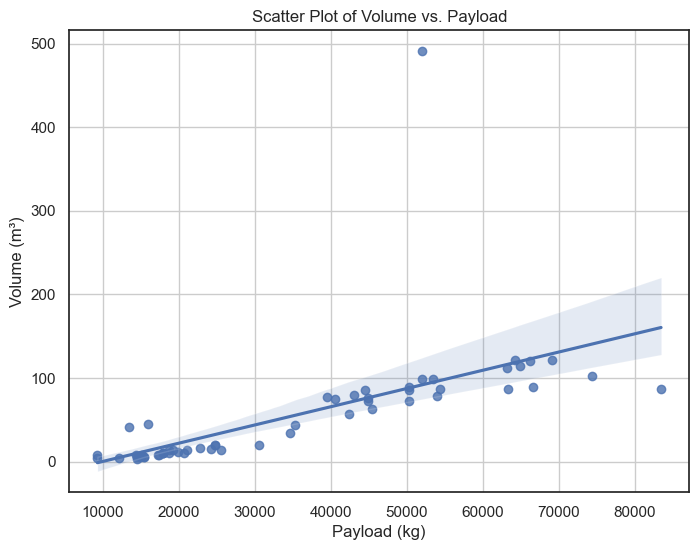

In [77]:
# Drop rows with missing values for visualization
df_clean = airplane_df.dropna()

# Scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(data=df_clean, x='payload', y='volume')
plt.title('Scatter Plot of Volume vs. Payload')
plt.xlabel('Payload (kg)')
plt.ylabel('Volume (m³)')
plt.grid()
plt.show()

The relation seems linear for lower and mid values of payload, but higher payload values seem to plateau, giving more a logistic relation. There also seems to exist a huge outlier in the data that could be an error.

In [ ]:
max_volume_index = df_clean['volume'].idxmax()
max_volume_row = df_clean.loc[max_volume_index]
max_volume_row

code_iata                     M11
code_icao                    MD11
full_name            Boeing MD-11
category                    MD-11
average_speed_mph             522
volume                  490.95696
payload                52037.2584
Name: 18, dtype: object

Researching online this aircraft is already retired, and the volume cargo capacity was high, around 300m3, but not the reported 500, so indeed seems an error but without repercussions as it should not match any equipment in flight.

In [ ]:
correlation = df_clean['volume'].corr(df_clean['payload'])
print(f'Correlation between Volume and Payload: {correlation}')

Correlation between Volume and Payload: 0.6139093489530223


C:\Users\Goncalo\AppData\Local\Temp\ipykernel_11912\746754551.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Payload Bin', y='Number of Aircrafts', data=payload_counts, palette='muted')


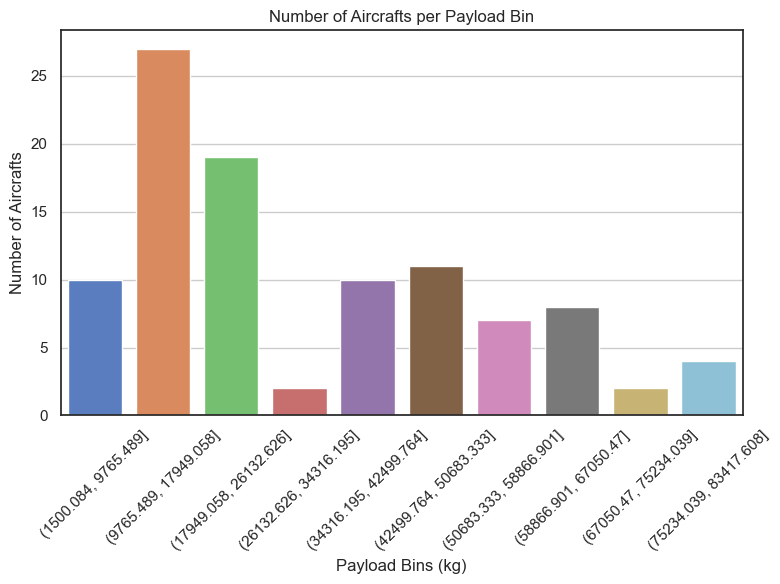

In [83]:
#define number of bins
num_bins = 10

# Create bins using pd.cut with equal-width intervals
airplane_df['payload_bin'] = pd.cut(airplane_df['payload'], bins=num_bins)

# Count the number of aircrafts in each payload bin
payload_counts = airplane_df['payload_bin'].value_counts().sort_index().reset_index()
payload_counts.columns = ['Payload Bin', 'Number of Aircrafts']

plt.figure(figsize=(8, 6))
sns.barplot(x='Payload Bin', y='Number of Aircrafts', data=payload_counts, palette='muted')
# Add labels and title
plt.title('Number of Aircrafts per Payload Bin')
plt.xlabel('Payload Bins (kg)')
plt.ylabel('Number of Aircrafts')
plt.xticks(rotation=45)
plt.grid(axis='y')
# Show the plot
plt.tight_layout()
plt.show()

As expected, theres a strong correlation between the two properties of volume and weight, and the number of aircrafts on the lower and mid payload range is much higher than on the high payload range, which means using a regression to estimate the volumes missing should give good accuracy.

Previously a mistake was made of confusing the *category* column with the *code_icao* column, this caused a large gap in the join, some good analysis came out of it in the end trying to fix the issue, but now i have fixed the error and left those previous cells comented out for reference

In [7]:
cargo_data_df = airplane_df[['volume', 'code_icao', 'payload']]
cargo_data_df.head()

,volume,code_icao,payload
0,86.74944,A388,83417.6077
1,120.12864,A35K,66242.9000
2,74.78400,B788,40610.8525
3,9.85872,MD82,17989.3965
4,3.92160,RJ85,12136.2925


In [15]:
cargo_data_df.count()

volume        57
code_icao    100
payload      100
dtype: int64

In [105]:
# Dropping the row without category
# cargo_data_df_clean = cargo_data_df.dropna(subset=['category']).sort_index()
# cargo_data_df_clean.count()

volume      56
category    99
payload     99
dtype: int64

In [135]:
cargo_data_df_clean.describe()

,volume,payload
count,56.000000,99.000000
mean,55.103203,31352.226278
std,71.539349,21163.579255
min,3.274080,1581.920000
25%,9.835920,14530.923900
50%,37.474080,21078.095300
75%,86.070000,45516.287550
max,490.956960,83417.607700


The Min and Max values seem too small and too large respectively, but clearing this requires some domain knowledge to make sure.

#### Question 2
Create a capacity table that includes capacity in weight and volume

In [ ]:
sampled_flight_events.columns

Index(['address', 'altitude', 'callsign', 'date', 'destination_iata',
       'destination_icao', 'equipment', 'event', 'flight', 'flight_id',
       'latitude', 'longitude', 'operator', 'origin_iata', 'origin_icao',
       'registration', 'time'],
      dtype='object')

In [9]:
# keeping only the relevant columns for the processing
sampled_flight_data = sampled_flight_events[['flight_id','destination_iata', 'destination_icao', 'equipment', 'origin_iata', 'origin_icao']]
sampled_flight_data.head()

,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao
15060,766610276,GUA,MGGT,A320,JFK,KJFK
1786,766571550,DOH,OTHH,A359,SIN,WSSS
63231,766627600,ACV,KACV,E75L,SFO,KSFO
87263,766634690,TUO,NZAP,R44,NaN,NaN
33198,766618800,SJC,KSJC,B38M,HNL,PHNL


In [ ]:
# checking results
filtered_df = sampled_flight_data[sampled_flight_data['flight_id'] == 766628228]
filtered_df

,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao
65436,766628228,SFO,KSFO,CRJ2,SBP,KSBP


In [32]:
# joining both tables, here sampled_flight_data has minimal processing done 
flights_with_cap_df = pd.merge(sampled_flight_data, cargo_data_df, left_on='equipment', right_on='code_icao', how='left')
flights_with_cap_df.head()

,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao,volume,code_icao,payload
0,766610276,GUA,MGGT,A320,JFK,KJFK,14.21808,A320,19279.6500
1,766571550,DOH,OTHH,A359,SIN,WSSS,99.19824,A359,53389.8000
2,766618800,SJC,KSJC,B38M,HNL,PHNL,10.69776,B38M,20646.0334
3,766629677,TLC,MMTO,LJ35,TGZ,MMTG,NaN,LJ35,1581.9200
4,766635033,SNA,KSNA,A320,SEA,KSEA,14.21808,A320,19279.6500


Some of the flights did not find a match between equipment and code_icao, they can only be dropped at this point

In [36]:
flights_with_cap_clean_df = flights_with_cap_df.dropna(subset=['code_icao']).reset_index(drop=True)

In [37]:
flights_with_cap_clean_df.shape

(618, 9)

In [38]:
summarize(flights_with_cap_df, 'flights and capacity joined')

=====Summary of flights and capacity joined=====
Shape: (618, 9)
NaN ratio:


,volume,destination_icao,destination_iata,flight_id,equipment,origin_iata,origin_icao,code_icao,payload
NaN Ratio,0.647249,0.161812,0.161812,0.0,0.0,0.0,0.0,0.0,0.0


This was because of using category to join the tables:  
        It seems some rows were duplicated (1000 -> 1410), but still expected to have a much higher matching ratio. It seems many categories in the *flight_events* dataset are not present in the *airplane_details* dataset, making it impossible to assess their cargo capacity. The only way to fix this would be to update the *airplane_details* dataset to include more recent categories in it.

In [48]:
flights_with_cap_df[flights_with_cap_df['category'].notna()].head()

,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao,volume,category,payload
10,766603897,JAX,KJAX,A320,JFK,KJFK,14.21808,A320,19279.65
11,766603897,JAX,KJAX,A320,JFK,KJFK,14.16336,A320,18785.30
12,766619360,YVR,CYVR,A321,YYZ,CYYZ,20.38320,A321,24717.50
13,766619360,YVR,CYVR,A321,YYZ,CYYZ,20.32848,A321,24717.50
36,766630103,SCL,SCEL,A320,IQQ,SCDA,14.21808,A320,19279.65


Here is the reason for the duplicated rows.  
The *airplane details* json has the same category 'A320' for two different airplanes, the Airbus A320-200 and the Airbus A320-200 neo, that have different cargo capacities. How to identify the correct one? There doesnt seem to be enough matching info in the datasets to make this distinction through other features like the average speed or aircraft name. The *airplane details* json contains the full aircraft names, that distinguishes them, but theres no way to match it witht he flight events data, who onlyl have the equipment column to id the aircraft type. 

In this case, we can take a few hypothesis to choose a single cargo capacity value:
- The number of Airbus A320-200 and Airbus A320-200 neo in the flights is simillar -> calculate the average of the cargo capacities. This would require domain knowledge and may differ for each category that has this issue, so not a great solution
- It's better for clients to have the planes with cargo capacity in exceess, than planning more cargo than the capacity of the aircraft -> choose the lowest value of the cargo capacity, this one seems the better alternative, as planning more cargo and then not being able to load it to the airplane is probably more hurtfull to the clients than the reverse.

Going with the second option and take the lowest capacity possible for each category of aircraft, either way the difference seems small, so the "wasted" cargo capacity should not be very significant.

In [131]:
# Sort by ascending payload values and drop duplicates in the flight id row to keep the lowest payload value for each flight
flights_with_mincap_df = flights_with_cap_df.sort_values('payload', ascending=True).drop_duplicates('flight_id')
flights_with_mincap_df[flights_with_mincap_df['category'].notna()].head()

,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao,volume,category,payload
942,766619199,DCA,KDCA,B737,DAL,KDAL,3.27408,B737,14530.9239
69,766605067,ATL,KATL,B737,AUS,KAUS,3.27408,B737,14530.9239
895,766622221,OAK,KOAK,B737,BUR,KBUR,3.27408,B737,14530.9239
868,766635247,STL,KSTL,B737,HOU,KHOU,3.27408,B737,14530.9239
185,766622348,MCO,KMCO,B737,CMH,KCMH,3.27408,B737,14530.9239


In [132]:
flights_with_mincap_df.count()

flight_id           985
destination_iata    941
destination_icao    943
equipment           983
origin_iata         938
origin_icao         940
volume              190
category            190
payload             190
dtype: int64

In [24]:
flights_with_mincap_df.nunique()

NameError: name 'flights_with_mincap_df' is not defined

In [128]:
summarize(flights_with_mincap_df, 'merged_dfs')

=====Summary of merged_dfs=====
Shape: (985, 10)
NaN ratio:


,payload,category,volume,origin_iata,origin_icao,destination_iata,destination_icao,equipment,flight_id,index
NaN Ratio,80.71066,80.71066,80.71066,4.771574,4.568528,4.467005,4.263959,0.203046,0.0,0.0


In [175]:
flights_with_mincap_df.reset_index(drop=True)
flights_with_mincap_df.head()

,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao,volume,category,payload
0,766619199,DCA,KDCA,B737,DAL,KDAL,3.27408,B737,14530.9239
1,766605067,ATL,KATL,B737,AUS,KAUS,3.27408,B737,14530.9239
2,766622221,OAK,KOAK,B737,BUR,KBUR,3.27408,B737,14530.9239
3,766635247,STL,KSTL,B737,HOU,KHOU,3.27408,B737,14530.9239
4,766622348,MCO,KMCO,B737,CMH,KCMH,3.27408,B737,14530.9239


Looking at these volume values, and searching online, the Boeing 737 should have a volume capacity higher than 3.2 m3, but cant really fix this issue lacking better data on airplane details 

In [176]:
clean_flights_with_mincap_df = flights_with_mincap_df.dropna(subset=['category']).reset_index()
clean_flights_with_mincap_df.shape


(190, 10)

In [177]:

clean_flights_with_mincap_df.head()

,index,flight_id,destination_iata,destination_icao,equipment,origin_iata,origin_icao,volume,category,payload
0,0,766619199,DCA,KDCA,B737,DAL,KDAL,3.27408,B737,14530.9239
1,1,766605067,ATL,KATL,B737,AUS,KAUS,3.27408,B737,14530.9239
2,2,766622221,OAK,KOAK,B737,BUR,KBUR,3.27408,B737,14530.9239
3,3,766635247,STL,KSTL,B737,HOU,KHOU,3.27408,B737,14530.9239
4,4,766622348,MCO,KMCO,B737,CMH,KCMH,3.27408,B737,14530.9239


#### Calculating Cargo Capacity

In [ ]:
#total_cargo = clean_flights_with_mincap_df.groupby(['origin_iata', 'destination_iata']).agg(
# Using the correct table with matching ICAO codes
total_cargo = flights_with_cap_clean_df.groupby(['origin_iata', 'destination_iata']).agg(
    total_payload = ('payload', 'sum'),
    total_volume = ('volume', 'sum')).reset_index()
total_cargo.head()

,origin_iata,destination_iata,total_payload,total_volume
0,ABQ,DAL,17355.6398,7.82496
1,ACE,CGN,21078.0953,14.03568
2,ADB,CGN,21078.0953,14.03568
3,ADE,CAI,44846.4433,75.51360
4,ADL,CNS,19279.6500,14.21808


#### Question 3
Presenting the data

In [45]:
# Create a pivot table for better visualization
pivot_table = total_cargo.pivot(index='origin_iata', columns='destination_iata', values='total_payload')
# Remove rows and columns with all NaN values (i.e., keep only matching values)
pivot_table_clean = pivot_table.dropna(how='all').dropna(axis=1,how='all')

In [47]:
pivot_table_clean.head(1)

destination_iata,ADD,AER,AKL,AMQ,AMS,ANC,ARN,ATL,AUS,AYQ,...,YHM,YLW,YUL,YVR,YXX,YYC,YYZ,ZAG,ZNZ,ZUH
origin_iata,,,,,,,,,,,,,,,,,,,,,
ABQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pivot_table_clean[pivot_table_clean['ADD'].notna()]

destination_iata,ADD,AER,AKL,AMQ,AMS,ANC,ARN,ATL,AUS,AYQ,...,YHM,YLW,YUL,YVR,YXX,YYC,YYZ,ZAG,ZNZ,ZUH
origin_iata,,,,,,,,,,,,,,,,,,,,,
DXB,40610.8525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pivoting the table this way is a good idea, but there is a huge number of destinations and departures anyway, so it is hard to visualize the results. 
In the end, i will plot the top ten origin-destination pairs based on total payload and respective volume

In [50]:
top_pairs = total_cargo.sort_values(by='total_payload', ascending=False).head(10).reset_index(drop=True)
top_pairs

,origin_iata,destination_iata,total_payload,total_volume
0,ORD,PVG,126466.5944,172.55040
1,SIN,SFO,103983.5564,198.39648
2,CTS,HND,99673.8131,149.26704
3,SIN,LHR,83417.6077,86.74944
4,LUX,LAX,74311.6807,101.79744
5,ANC,LCK,74311.6807,101.79744
6,HNL,SYD,74311.6807,101.79744
7,JFK,LAX,70091.9091,83.37504
8,YUL,DOH,69064.6498,121.75200
9,ATL,DOH,69064.6498,121.75200


In [51]:
x_labels = [f"{row['origin_iata']} - {row['destination_iata']}" for _, row in top_pairs.iterrows()]
x_labels

['ORD - PVG',
 'SIN - SFO',
 'CTS - HND',
 'SIN - LHR',
 'LUX - LAX',
 'ANC - LCK',
 'HNL - SYD',
 'JFK - LAX',
 'YUL - DOH',
 'ATL - DOH']

C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\1182760432.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels,rotation=45)
C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\1182760432.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels,rotation=45)


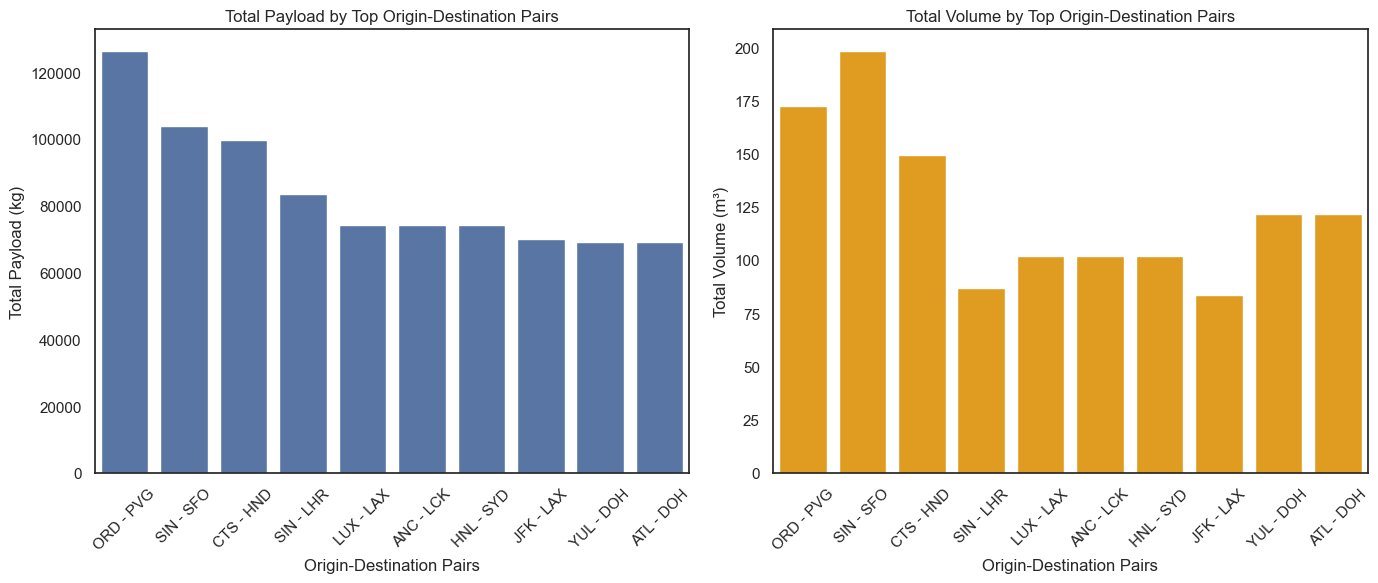

In [52]:
# Set up the figure and axes for two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotting total payload bars on the first subplot
sns.barplot(x=x_labels, y='total_payload', data=top_pairs, ax=ax1, color='b')
ax1.set_title('Total Payload by Top Origin-Destination Pairs')
ax1.set_xlabel('Origin-Destination Pairs')
ax1.set_ylabel('Total Payload (kg)')
ax1.set_xticklabels(x_labels,rotation=45)

# Plotting total volume bars on the second subplot
sns.barplot(x=x_labels, y='total_volume', data=top_pairs, ax=ax2, color='orange')
ax2.set_title('Total Volume by Top Origin-Destination Pairs')
ax2.set_xlabel('Origin-Destination Pairs')
ax2.set_ylabel('Total Volume (m³)')
ax2.set_xticklabels(x_labels,rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

----

#### Combining the Analysis

Having worked on the sample dataset, extend now the results to a concise workflow that, given the datasets, outputs the table of capacity per flight and plots graphs of total payload and volume per use defined fields

In [53]:
def read_flight_events(dir):
    """
    Read the csv files of flight event data from a directory and concatenates the relevant columns into one df
    """
    flight_events_list = os.listdir(dir)
    print(f'There are {len(flight_events_list)} files in the "{dir.split('/')[-1]}" directory.')
    relevant_cols = ['flight_id','destination_iata', 'destination_icao', 'equipment', 'origin_iata', 'origin_icao', 'operator', 'date']
    chunks_list = []
    for file in flight_events_list:
        print(f'Reading data from {file}.')
        for chunk in pd.read_csv(dir + '/' + file, delimiter=';', chunksize=10_000, usecols=relevant_cols): # Load the CSV
            chunks_list.append(chunk)
    
    combined_df =pd.concat(chunks_list, ignore_index=True)
    print(f'Shape of combined df: {combined_df.shape}.')
    print(combined_df.head())
    return combined_df
        

In [54]:
flight_data = read_flight_events('./data/flight_events')

There are 7 files in the "flight_events" directory.
Reading data from 2022-10-03.csv.
Reading data from 2022-10-04.csv.
Reading data from 2022-10-05.csv.
Reading data from 2022-10-06.csv.
Reading data from 2022-10-07.csv.
Reading data from 2022-10-08.csv.
Reading data from 2022-10-09.csv.
Shape of combined df: (700000, 8).
         date destination_iata destination_icao equipment  flight_id operator  \
0  2022-10-03              PDX             KPDX      A119  766465831      NaN   
1  2022-10-03              HNL             PHNL      B77L  766473984      FDX   
2  2022-10-03              HNL             PHNL      B77L  766473984      FDX   
3  2022-10-03              HNL             PHNL      B77L  766473984      FDX   
4  2022-10-03              PER             YPPH      B789  766481217      QFA   

  origin_iata origin_icao  
0         NaN         NaN  
1         MEM        KMEM  
2         MEM        KMEM  
3         MEM        KMEM  
4         FCO        LIRF  


In [55]:
def read_airplane_data(filepath):
    """
    Read the Json file with airplane data from a filepath and outputs as a df
    """
    cargo_cols = ['code_icao', 'volume', 'payload']
    airplane_df = pd.read_json(filepath, lines=True)
    cargo_data_df = airplane_df[cargo_cols]
    print(f'Shape of combined df: {cargo_data_df.shape}.')
    print(cargo_data_df.head())
    return cargo_data_df


In [56]:
airplane_data = read_airplane_data('./data/airplane_details.json')

Shape of combined df: (100, 3).
  code_icao     volume     payload
0      A388   86.74944  83417.6077
1      A35K  120.12864  66242.9000
2      B788   74.78400  40610.8525
3      MD82    9.85872  17989.3965
4      RJ85    3.92160  12136.2925


In [57]:
def clean_flight_data(df):
    """
    Given a flight events df, processes and cleans the data
    Drops NAN values in relevant columns and groups by unique flight id
    """
    df_clean = df.dropna(subset=['origin_iata', 'destination_iata', 'equipment']).reset_index(drop=True)
    print(f'Shape of clean flight data: {df_clean.shape}.')
    df_group = df_clean.groupby('flight_id').first().reset_index()
    print(f'Shape of grouped flight data: {df_group.shape}.')
    print(df_group.head())
    return df_group


In [58]:
flight_data_clean = clean_flight_data(flight_data)

Shape of clean flight data: (633193, 8).
Shape of grouped flight data: (165980, 8).
   flight_id        date destination_iata destination_icao equipment operator  \
0  766473984  2022-10-03              HNL             PHNL      B77L      FDX   
1  766481217  2022-10-03              PER             YPPH      B789      QFA   
2  766481849  2022-10-03              LHR             EGLL      B789      QFA   
3  766489649  2022-10-03              ICN             RKSI      A359      AAR   
4  766492623  2022-10-03              JFK             KJFK      B77W      KAL   

  origin_iata origin_icao  
0         MEM        KMEM  
1         FCO        LIRF  
2         PER        YPPH  
3         ATL        KATL  
4         ICN        RKSI  


In [59]:
def clean_airplane_data(df):
    """
    Clean the airplane data by dropping the Nan values in the code_icao col
    Keep the lowest payload values for repeated aircraft categories
    """
    airplane_data_clean = df.dropna(subset=['code_icao']).reset_index(drop=True)
    airplane_data_min_cargo = airplane_data_clean.sort_values('payload', ascending=True).drop_duplicates('code_icao').reset_index(drop=True)
    print(f'Shape of cleaned airplane data: {airplane_data_min_cargo.shape}.')
    print(airplane_data_min_cargo.head())
    return airplane_data_min_cargo

In [60]:
airplane_data_clean = clean_airplane_data(airplane_data)

Shape of cleaned airplane data: (97, 3).
  code_icao  volume    payload
0      LJ35     NaN  1581.9200
1      WW24     NaN  1977.4000
2      J328     NaN  3411.0150
3      YK40     NaN  4150.5626
4      CRJ1     NaN  6278.2450


In [61]:
def build_total_cargo_table(flights_df, airplane_df):
    """
    Joins the two tables and cleans the combined data
    """
    # Merge the dfs 
    merged_dfs = pd.merge(flights_df, airplane_df, left_on='equipment', right_on='code_icao', how='left')
    clean_merged_dfs = merged_dfs.dropna(subset=['code_icao']).reset_index(drop=True)
    print(f'Shape of capacity data: {clean_merged_dfs.shape}.')
    print(clean_merged_dfs.head())
    return clean_merged_dfs

In [62]:
capacity_table = build_total_cargo_table(flight_data_clean, airplane_data_clean)

Shape of capacity data: (103033, 11).
   flight_id        date destination_iata destination_icao equipment operator  \
0  766473984  2022-10-03              HNL             PHNL      B77L      FDX   
1  766481217  2022-10-03              PER             YPPH      B789      QFA   
2  766481849  2022-10-03              LHR             EGLL      B789      QFA   
3  766489649  2022-10-03              ICN             RKSI      A359      AAR   
4  766492623  2022-10-03              JFK             KJFK      B77W      KAL   

  origin_iata origin_icao code_icao     volume     payload  
0         MEM        KMEM      B77L   86.27520  63233.2972  
1         FCO        LIRF      B789   99.19824  51991.7782  
2         PER        YPPH      B789   99.19824  51991.7782  
3         ATL        KATL      A359   99.19824  53389.8000  
4         ICN        RKSI      B77W  121.75200  69064.6498  


In [63]:
def total_cargo_per_fields(capacity_table, field):
    """
    Given the capacity table and a list of fields, outputs the total payload, volume and number of flights
    per specified fields
    """
    total_cargo_per_field = capacity_table.groupby(field).agg(
            total_payload = ('payload', 'sum'),
            total_volume = ('volume', 'sum'),
            number_flights = ('flight_id', 'count')).reset_index()
    print(f'Shape of cargo data per {'-'.join(field)}: {total_cargo_per_field.shape}.')
    print(total_cargo_per_field.sort_values('total_payload', ascending=False).head())
    return total_cargo_per_field

In [64]:
total_cargo1 = total_cargo_per_fields(capacity_table, ['destination_iata', 'origin_iata'])

Shape of cargo data per destination_iata-origin_iata: (16088, 5).
     destination_iata origin_iata  total_payload  total_volume  number_flights
2948              CJU         GMP   6.705822e+06    6897.13680             252
5583              GMP         CJU   6.462543e+06    6450.57600             250
3380              CTS         HND   5.206889e+06    8095.33152             119
8693              LHR         JFK   5.177970e+06    9048.27120              88
6274              HND         CTS   5.054006e+06    7834.99200             115


In [65]:
total_cargo2 = total_cargo_per_fields(capacity_table, ['destination_iata', 'origin_iata', 'date'])

Shape of cargo data per destination_iata-origin_iata-date: (62816, 6).
      destination_iata origin_iata        date  total_payload  total_volume  \
22064              GMP         CJU  2022-10-09   1.177216e+06    1139.55312   
11241              CJU         GMP  2022-10-09   1.169022e+06    1242.85536   
22058              GMP         CJU  2022-10-03   1.006045e+06    1030.02192   
11235              CJU         GMP  2022-10-03   9.851397e+05    1067.21328   
11240              CJU         GMP  2022-10-08   9.755750e+05    1055.41200   

       number_flights  
22064              46  
11241              43  
22058              38  
11235              36  
11240              35  


In [66]:
total_cargo3 = total_cargo_per_fields(capacity_table, ['operator'])

Shape of cargo data per operator: (662, 4).
    operator  total_payload  total_volume  number_flights
1        AAL   1.432102e+08  132283.64832            5767
549      SWA   1.419440e+08   74384.04240            7555
610      UAL   1.308044e+08  132622.26480            4871
184      DAL   1.243202e+08  123001.80480            4914
609      UAE   7.339907e+07  108890.86656            1013


In [67]:
total_cargo4 = total_cargo_per_fields(capacity_table, ['operator', 'date'])

Shape of cargo data per operator-date: (3695, 5).
     operator        date  total_payload  total_volume  number_flights
10        AAL  2022-10-07   2.242242e+07   20561.45952             907
11        AAL  2022-10-08   2.237632e+07   20396.19600             908
6         AAL  2022-10-03   2.213453e+07   20117.34288             901
3035      SWA  2022-10-08   2.176995e+07   11427.17760            1158
3030      SWA  2022-10-03   2.171592e+07   11397.62880            1156


In [68]:
def plot_top_total_cargo(data):

    top_cargo_data = data.sort_values(by='total_payload', ascending=False).head(10).reset_index(drop=True)
    # Set up the figure and axes for two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    x_labels = top_cargo_data.iloc[:, :-3].astype(str).agg(' '.join, axis=1)
    fields = ' - '.join(top_cargo_data.columns[:-3])

    # Plotting total payload bars on the first subplot
    sns.barplot(x=x_labels, y='total_payload', data=top_cargo_data, ax=ax1, color='b')
    ax1.set_title(f'Total Payload by Top {fields}')
    ax1.set_xlabel(f'{fields}')
    ax1.set_ylabel('Total Payload (kg)')
    ax1.set_xticklabels(x_labels,rotation=45)

    # Plotting total volume bars on the second subplot
    sns.barplot(x=x_labels, y='total_volume', data=top_cargo_data, ax=ax2, color='orange')
    ax2.set_title(f'Total Volume by Top {fields}')
    ax2.set_xlabel(f'{fields}')
    ax2.set_ylabel('Total Volume (m³)')
    ax2.set_xticklabels(x_labels,rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels,rotation=45)
C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels,rotation=45)


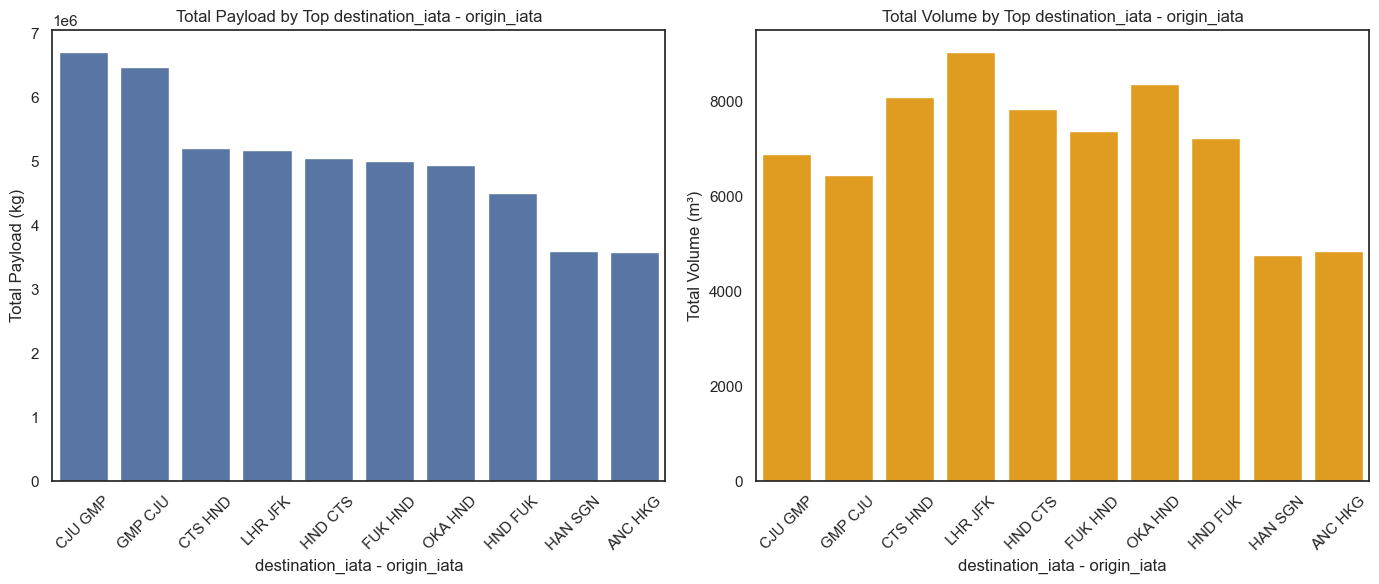

In [69]:
plot_top_total_cargo(total_cargo1)

C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels,rotation=45)
C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels,rotation=45)


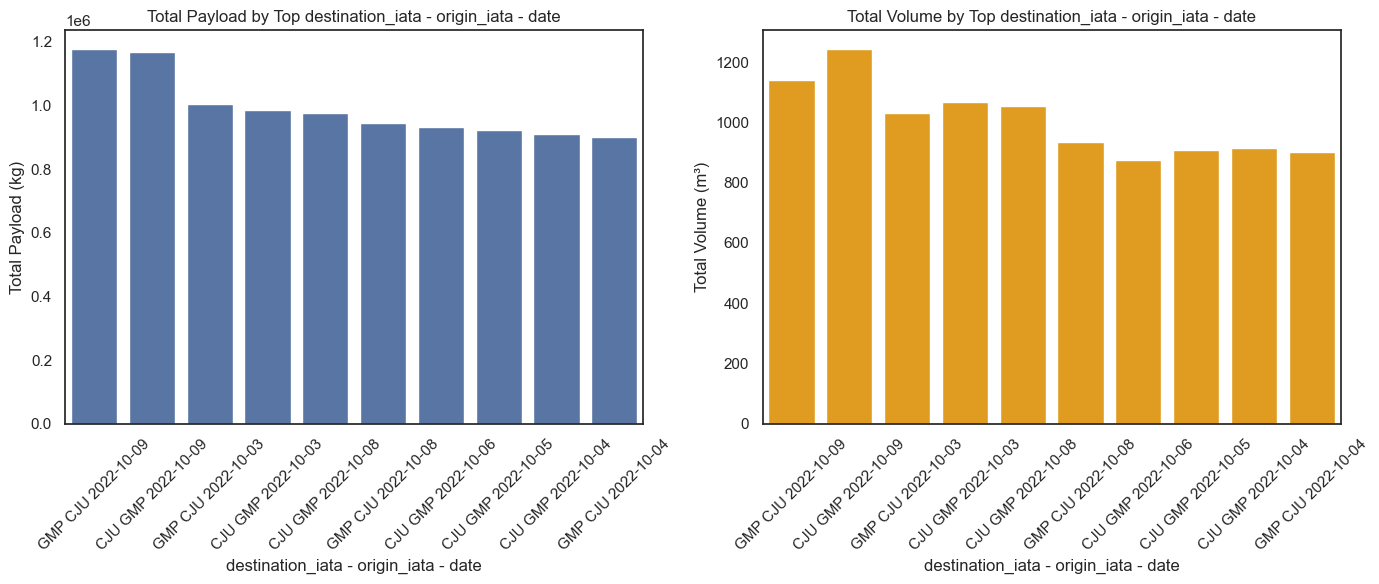

In [70]:
plot_top_total_cargo(total_cargo2)

C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels,rotation=45)
C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels,rotation=45)


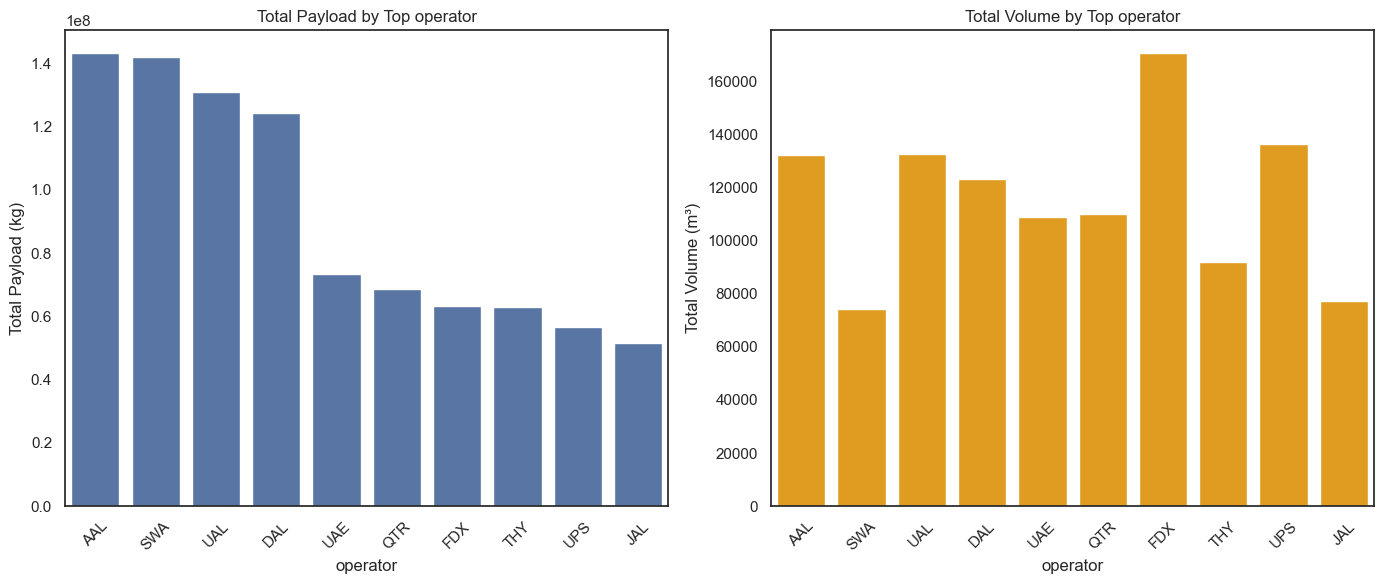

In [71]:
plot_top_total_cargo(total_cargo3)

C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels,rotation=45)
C:\Users\Goncalo\AppData\Local\Temp\ipykernel_2120\3251108115.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels,rotation=45)


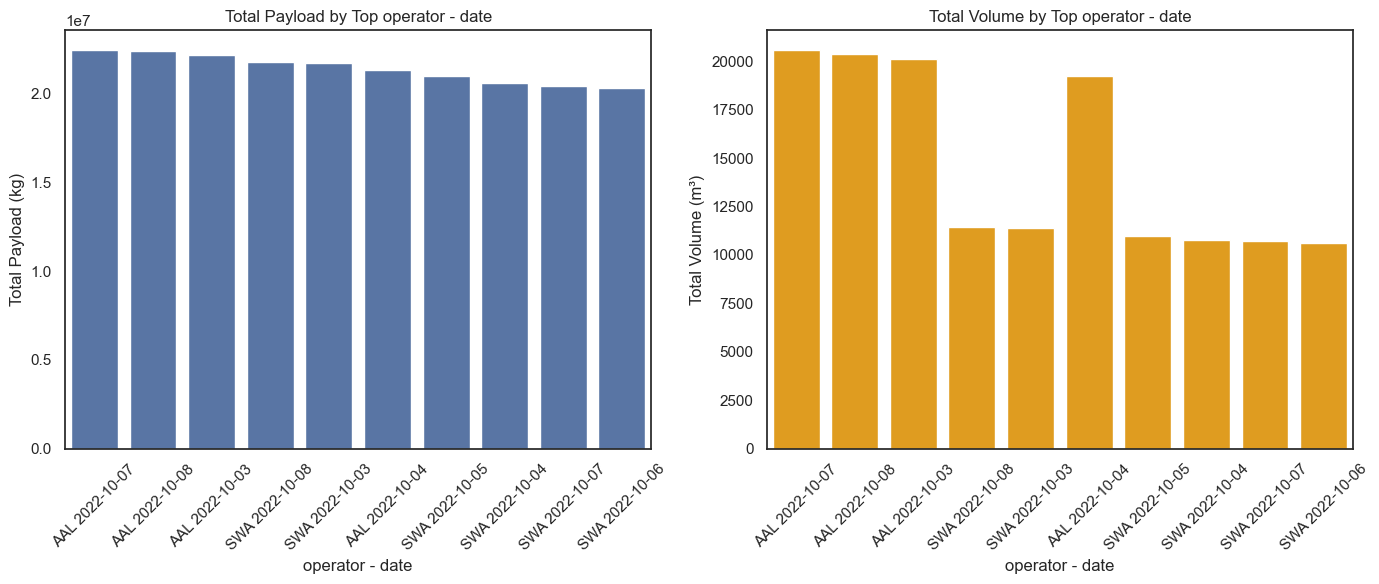

In [72]:
plot_top_total_cargo(total_cargo4)

#### Fixing the Volume issue


As analysed in Question 1 section, almost 50% of volume data is missing in the aiplanes details json.  
This is very significant for an accurate assessment of cargo capacity so I'll try to estimate these values from the payload data and evaluate the accuracy

Correlation between the 2 fields is high.

In [521]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [565]:
airplane_data = read_airplane_data('./data/airplane_details.json')

Shape of combined df: (100, 3).
  category     volume     payload
0     A380   86.74944  83417.6077
1     A350  120.12864  66242.9000
2     B787   74.78400  40610.8525
3     MD80    9.85872  17989.3965
4       RJ    3.92160  12136.2925


In [548]:
def remove_outliers(df):
    """
    Calculate Interquantile range for the volume column
    """
    Q1 = df['volume'].quantile(0.25)
    Q3 = df['volume'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    df_cleaned = df[(df['volume'] >= lower_bound) & (df['volume'] <= upper_bound)]
    print(f'Shape of no outliers df: {df_cleaned.shape}.')
    return df_cleaned

In [549]:
train_test_data_clean = remove_outliers(airplane_data)

Shape of no outliers df: (56, 3).


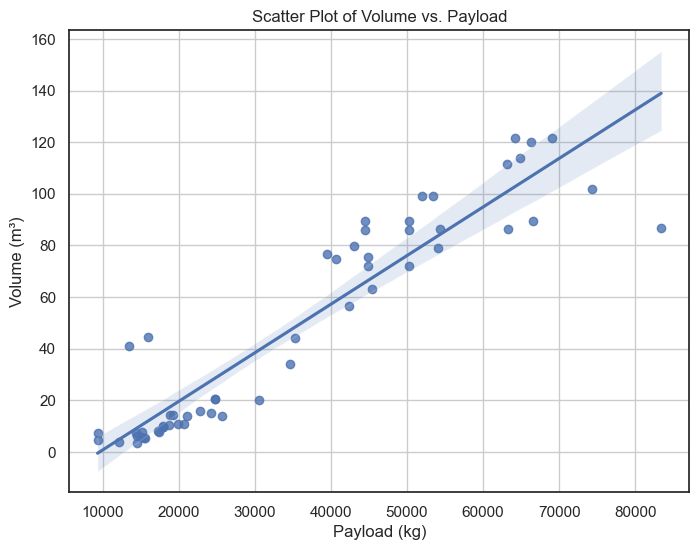

In [550]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(data=train_test_data_clean, x='payload', y='volume')
plt.title('Scatter Plot of Volume vs. Payload')
plt.xlabel('Payload (kg)')
plt.ylabel('Volume (m³)')
plt.grid()
plt.show()

In [619]:
# Define features and target variable
X = train_test_data_clean[['payload']]  # Features
y = train_test_data_clean['volume']      # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [620]:
# Initialize and fit the model 
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [621]:
# Predict on the test set and evaluate performance
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Squared Error: 376.95
R² Score: 0.74


In [622]:
# Predict on the original DataFrame where volume is missing
missing_mask = airplane_data['volume'].isna()
predicted_values = model.predict(airplane_data[['payload']][missing_mask])

# Fill in missing values in the original DataFrame with predicted values
new_airplane_data = airplane_data.copy()
new_airplane_data.loc[missing_mask, 'volume'] = predicted_values

In [623]:
new_airplane_data_clean = remove_outliers(new_airplane_data)

Shape of no outliers df: (99, 3).


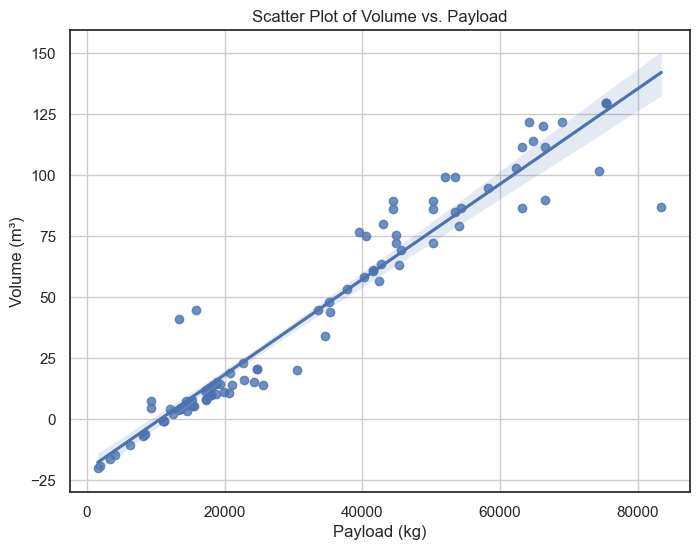

In [624]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(data=new_airplane_data_clean, x='payload', y='volume')
plt.title('Scatter Plot of Volume vs. Payload')
plt.xlabel('Payload (kg)')
plt.ylabel('Volume (m³)')
plt.grid()
plt.show()

conclusion: Using a Linear regression model we can quickly estimate volume values for the missing aircraft categories but the error is still relatively significant. For low payload values, volume values turn out negative, which is obviously impossible.

### Final Thoughts

Even though the volume estimations are not very accurate, this seems like a good direction to improve on the data available. Estimating using only 50 rows really hurts the accuracy.

The analysis of data is also quite good and useful, specially the outlier analysis and the graphs, but combining all the insights into a single presentation would have been even better to comunicate the results of the analysis.

Another useful tool would have been to create a general function that given some parameters can return the cargo capacity, since a cargo capacity table is now available, this can also expand on time analysis and spewecific airports. This tool could also be changed into an API later on
